In [22]:
zero_cutoff = 0.02
differential = True
hdlc = True
decimate_by = 2
dataFile = 'data-aq.wav'


[[-0. -0.]
 [-0. -0.]
 [-0. -0.]
 ...
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]]
42496


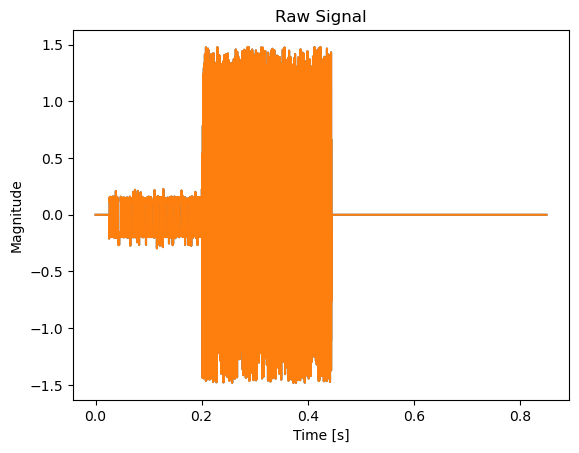

In [27]:
import numpy as np
import scipy.signal as sig
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import math
import sys
#
# DATA LOAD
#

# read the wave file
# Data6 shows a need for bit stuffing
# fs, rf = wf.read('data6-aq.wav') 
# Data7 makes sure to flip more often 
# fs, rf = wf.read('data7-aq.wav')
# Data8 has differential encoding and bit inversion
fs, rf = wf.read(dataFile)

sf = {
    np.dtype('int16'): 2**15,
    np.dtype('int32'): 2**32,
    np.dtype('float32'): 1,
    np.dtype('float64'): 1,
}[rf.dtype]

rf = (rf[:]) / sf
# rf = (rf[:, 0] + rf[:, 1]) / sf


print(rf)
print(len(rf))

# plt.subplot(1, 2, 1)
plt.title('Raw Signal')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.plot(np.arange(0, len(rf)) / fs, rf)


[-0.20995922 -0.15623726 -0.18772668 ...  0.666615   -0.11876759
 -0.04493233]


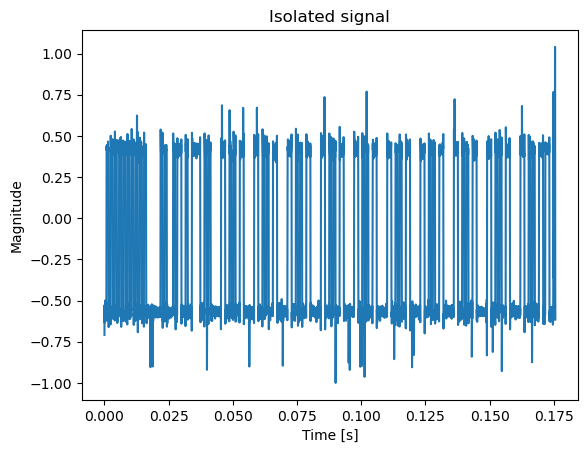

In [28]:
# Decimate the data to make processing simpler
fs = fs // decimate_by
rf = rf[::decimate_by]

# Thanks to Tomasz for a lot of inspiration
# https://mightydevices.com/index.php/2019/08/decoding-fsk-transmission-recorded-by-rtl-sdr-dongle/
audio_mag = np.abs(rf)
# mag threshold level
data_start_threshold = 0.02

# indices with magnitude higher than threshold
audio_indices = np.nonzero(audio_mag > data_start_threshold)[0]
# limit the signal
audio = rf[np.min(audio_indices) : np.max(audio_indices)]
if len(audio[0]) != 1:
    audio = audio[:,0]
    
print(audio)

audio_mag = np.abs(audio)
# Again, use the max of the first quarter of data to find the end (noise)
data_end_threshold = np.max(audio_mag[:round(len(audio_mag)/4)])*1.05

audio_indices = np.nonzero(audio_mag > data_end_threshold)[0]
# Use the data not found above and normalize to the max found
if len(audio_indices) > 0:
    audio = audio[ : np.min(audio_indices)] / (data_end_threshold/1.05)

# plt.subplot(1, 2, 2)
plt.title('Isolated signal')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.plot(np.arange(0, len(audio)) / fs, audio)

[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0
 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0
 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0
 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0
 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1
 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0]


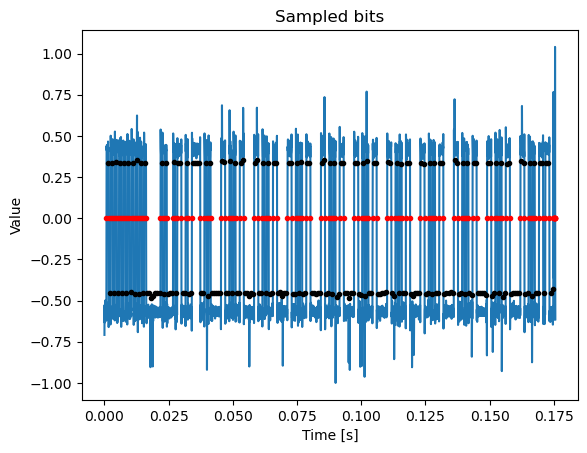

In [35]:
'''
This next chunk finds all the zero crossings, bit rate and bits
'''
zero_cross = [] 
for i in range(len(audio)):
#     print(audio[i-1])
    if audio[i -1] < 0 and audio[i] > 0:
        zero_cross += [(i, (audio[i -1]+audio[i])/2)]
    if audio[i -1] > 0 and audio[i] < 0:
        zero_cross += [(i, (audio[i -1]+audio[i])/2)]

# Get the first 10 zero crossings, ignoring the first as it may be offset
first_ten = zero_cross[1:11]

samples_per_bit = first_ten[len(first_ten)-1][0] - first_ten[0][0]
samples_per_bit = samples_per_bit/(len(first_ten)-1)
samples_per_bit_raw = samples_per_bit

# We will be using this to index arrays, so lets floor to the nearest integer
samples_per_bit = math.floor(samples_per_bit)

sampled_bits = []
bits = []
# Let's iterate over the chunks of data between zero crossings
for i in range(len(zero_cross))[:-1]:
    # Now let's iterate over the bits within the zero crossings
    # Note, let's add an extra 1/8th of a sample just in case
    for j in range(math.floor((zero_cross[i+1][0]-zero_cross[i][0] + samples_per_bit/8 )/samples_per_bit)):
        # Let's offset by 1 sample in case we catch the rising and falling edge
        start = zero_cross[i][0]+j*samples_per_bit+1
        end =   zero_cross[i][0]+j*samples_per_bit+samples_per_bit-1
        sampled_bits += [(zero_cross[i][0]+j*samples_per_bit+samples_per_bit/2, np.average(audio[start:end]))]
        bits += [np.average(audio[start:end]) >= zero_cutoff *1]

# Let's convert the true/false data into uint8s for later use
bits = (np.array(bits)).astype(np.uint8)

print(bits)

Bits = bits

# plt.subplot(2, 2, 3)
plt.title('Sampled bits')
plt.xlabel('Time [s]')
plt.ylabel('Value')
plt.plot(np.arange(0, len(audio)) / fs, audio)
plt.plot([(x[0]-.5) / fs for x in zero_cross], [0 for x in zero_cross], ".r")
plt.plot([(x[0]) / fs for x in sampled_bits], [x[1]*.8 for x in sampled_bits], ".k")

Raw data [126, 24, 165, 11, 175, 80, 175, 80, 175, 80, 175, 80, 175, 80, 175, 80, 175, 80, 175, 80, 175, 80, 175, 80]
As hex 7e 18 a5 0b af 50 af 50 af 50 af 50 af 50 af 50 af 50 af 50 af 50 af 50: 


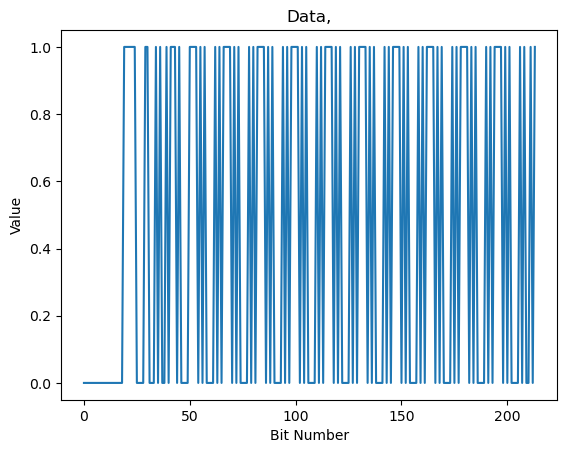

In [42]:
'''
Now let's extract the raw data
'''

bits = Bits

# https://pysdr.org/content/rds.html#differential-decoding
bits = (bits[1:] - bits[0:-1]) % 2
bits = bits.astype(np.uint8)

current_data = 0
start_data_offset = 0
data = []
found_start = False
for b in range(len(bits)):
    bit = bits[b]
    # Each byte is sent in order but the bits are sent reverse order
    current_data = current_data >> 1
    current_data += (bit*0x80)
    current_data &= 0xff

    # We've already found the start flag, time to store each byte
    if found_start:
        if ((b - start_data_offset) % 8) == 0:  
            data.append(current_data)
            current_data = 0
        continue

    # Have we found the flag? 0x7E
    if(current_data == 0b01111110) and b > 4 and not found_start:
        found_start = True
        start_data_offset = b
        data.append(0x7e)
        current_data = 0
    if(current_data == 0b10000001) and b > 4 and not found_start:
        found_start = True
        start_data_offset = b
        data.append(0x7e)
        # Invert the bit value since we found an inverted flag
        bits = (np.array([x for x in bits]) < 1 ).astype(np.uint8)
        current_data = 0


print("Raw data %s" % data)
hex_string = " ".join("%02x" % b for b in data)
print("As hex %s: " % hex_string)


# plt.subplot(2, 2, 4)
plt.title('Data,')
plt.xlabel('Bit Number')
plt.ylabel('Value')
plt.plot(bits)

plt.show()